In [1]:
import pandas as pd
import numpy as np
import os
from env import host, user, password
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
import scipy
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
import wrangle
import viz_explore
import scipy.stats as stats
import model

from sklearn.cluster import KMeans

In [2]:
# THE WRANGLE FUNCTION PERFORMS THE FOLLOWIN, IN BROAD STROKES:
# 1. Get the data via SQL query
# 2. Clean and prep the data
# 3. Encode the appropriate columns (only ['county'] for now)
# 4. Split the data: train, validate, test and X_ vs y_ splits as well
# 5. Scale the data (all train, validate and test, and all X_ and y_ splits are scaled)

df, train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, \
train_scaled, X_train_scaled, y_train_scaled, validate_scaled, X_validate_scaled, \
y_validate_scaled, test_scaled, X_test_scaled, y_test_scaled \
= wrangle.wrangle_zillow()

In [3]:
X_train_scaled

,parcelid,bathrooms,bedrooms,condition,sq_ft,full_baths,latitude,longitude,lot_size,census_tract,...,age,sq_ft_per_bathroom,sq_ft_per_bedroom,sq_ft_per_room,has_half_bath,tax_rate,price_per_sq_ft,Los_Angeles,Orange,Ventura
0,0.000849,0.333333,0.333333,0.454545,0.515721,0.5,0.573098,0.520347,0.001129,0.000365,...,0.584,0.494556,0.366901,0.587500,0.0,0.544719,0.161422,1.0,0.0,0.0
1,0.024477,1.000000,1.000000,0.454545,0.890830,1.0,0.076040,0.966372,0.001715,0.296869,...,0.208,0.494137,0.254749,0.907011,0.0,0.140196,0.492855,0.0,1.0,0.0
2,0.021369,0.333333,0.666667,0.454545,0.326638,0.5,0.269144,0.773711,0.000927,0.297648,...,0.392,0.313233,0.142510,0.074527,0.0,0.564074,0.355375,0.0,1.0,0.0
3,0.012255,0.333333,0.666667,0.454545,0.455459,0.5,0.343177,0.629829,0.000771,0.005983,...,0.384,0.436767,0.193685,0.536170,0.0,0.580565,0.346178,1.0,0.0,0.0
4,0.011818,0.333333,0.333333,0.636364,0.211354,0.5,0.300060,0.686613,0.001390,0.006411,...,0.280,0.202680,0.185532,0.328246,0.0,0.413904,0.602933,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22156,0.013912,0.333333,0.666667,0.454545,0.453275,0.5,0.408222,0.772092,0.001340,0.005400,...,0.480,0.434673,0.192818,0.534310,0.0,0.469528,0.422891,1.0,0.0,0.0
22157,0.021939,0.666667,1.000000,0.454545,0.986900,0.5,0.230682,0.770133,0.000904,0.297642,...,0.384,0.711893,0.283372,0.131659,1.0,0.351378,0.290606,0.0,1.0,0.0
22158,0.007112,0.333333,0.333333,0.454545,0.219214,0.5,0.477261,0.630094,0.019765,0.001420,...,0.080,0.210218,0.190216,0.334942,0.0,0.411003,0.794560,1.0,0.0,0.0
22159,0.002819,0.333333,0.333333,0.636364,0.193450,0.5,0.698763,0.478926,0.091468,0.011084,...,0.200,0.185511,0.174863,0.312996,0.0,0.811826,0.446185,1.0,0.0,0.0


# CLUSTERING ON THE FOLLOWING VARIABLES:
- sq_ft, price_per_sq_ft, tax_rate


In [4]:
# X_train_scaled.head().T

Step 1: get your k

In [5]:
# list of variables I will cluster on. 
cluster_vars = ['sq_ft', 'price_per_sq_ft', 'tax_rate']
cluster_name = 'good_deal_or_not_?'
k_range = range(2,20)

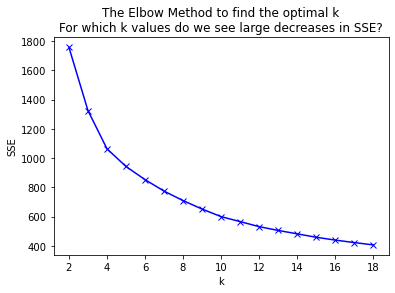

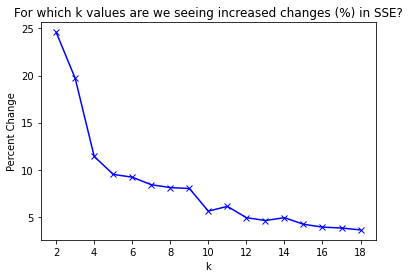

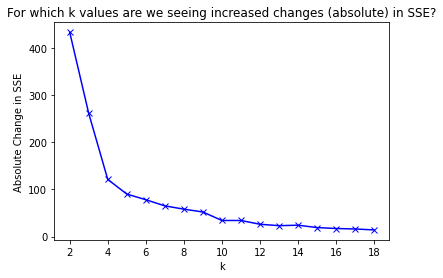

,k,sse,delta,pct_delta
0,2,1757.361647,433.0,24.6
1,3,1324.630069,261.0,19.7
2,4,1063.284450,121.0,11.4
3,5,942.272573,90.0,9.5
4,6,852.381681,78.0,9.2
5,7,773.905301,65.0,8.4
6,8,708.999425,58.0,8.1
7,9,651.295921,52.0,8.0
8,10,599.286006,34.0,5.6
9,11,565.479367,34.0,6.1


In [6]:
model.find_k(X_train_scaled, cluster_vars, k_range)

# Looks like k=5 seems happy

In [7]:
k = 5

Step 2: create kmeans object and fit

In [8]:
kmeans = model.create_clusters(X_train_scaled, k, cluster_vars)

Step 3: get centroids

In [9]:
centroid_df = model.get_centroids(kmeans, cluster_vars, cluster_name)

Step 4: label observations and append to EACH?? X dataframe : (

In [10]:
test_df = X_train_scaled.copy()

In [11]:
centroid_df

,good_deal_or_not_?,centroid_sq_ft,centroid_price_per_sq_ft,centroid_tax_rate
0,0,0.355665,0.353695,0.480207
1,1,0.729038,0.468711,0.396755
2,2,0.396411,0.458085,0.224684
3,3,0.347529,0.690335,0.464534
4,4,0.515540,0.300010,0.784879


In [12]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df):
    for i in range(len([X_train_scaled,X_validate_scaled,X_test_scaled])):
        clusters = pd.DataFrame(kmeans.predict([X_train_scaled,X_validate_scaled,X_test_scaled][i][cluster_vars]), 
                            columns=[cluster_name], index=[X_train_scaled,X_validate_scaled,X_test_scaled][i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        [X_train_scaled,X_validate_scaled,X_test_scaled][i] = pd.concat([[X_train_scaled,X_validate_scaled,X_test_scaled][i], clusters_centroids], axis=1)
    return X_train_scaled,X_validate_scaled,X_test_scaled

In [20]:
X_train_scaled,X_validate_scaled,X_test_scaled = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

In [21]:
X_train_scaled.head().T

,0,1,2,3,4
parcelid,0.000849,0.024477,0.021369,0.012255,0.011818
bathrooms,0.333333,1.000000,0.333333,0.333333,0.333333
bedrooms,0.333333,1.000000,0.666667,0.666667,0.333333
condition,0.454545,0.454545,0.454545,0.454545,0.636364
sq_ft,0.515721,0.890830,0.326638,0.455459,0.211354
full_baths,0.500000,1.000000,0.500000,0.500000,0.500000
latitude,0.573098,0.076040,0.269144,0.343177,0.300060
longitude,0.520347,0.966372,0.773711,0.629829,0.686613
lot_size,0.001129,0.001715,0.000927,0.000771,0.001390
census_tract,0.000365,0.296869,0.297648,0.005983,0.006411
